<!--Header-->
<div>
    <div class="row" style="color: #4D4D4D;font-size: 15px;padding-bottom: 20px">
        <div class="col-md-7">
            <img src="http://materials.cv.uoc.edu/cdocent/common/img/logo-uoc.png" alt="Logo UOC" class="img-responsive" style="margin:20px 0px 0px">
        </div>
        <div class="col-md-5">
            <h1 style="margin:15px 0px 0px;font-size: 40px;">Evaluación de modelos de clasificación</h1>
            <div style="text-align:left;margin-top: 5px;"></div>
        </div>
    </div>
    <div class="row" style="background: #FCB517;padding: 10px 20px;">
        <div class="col-md-6">
            <div>PID_00233252</div>
        </div>
        <div class="col-md-6">
            <div style="text-align:right;">Autor: Xavier Duran Albareda <span style="margin-left: 30px;">Coordinación: Julià Minguillón</span></div>
        </div>
    </div>
</div>
<!--/Header-->

## Introducción

Los problemas de clasificación son uno de los más comunes dentro del aprendizaje automático. Se trata de un aprendizaje supervisado, es decir, algoritmos que a partir de un conjunto de datos etiquetados generalizan un modelo que haga una predicción lo más precisa posible de la etiqueta en un nuevo conjunto de datos del mismo tipo.

![ML](images/ml_algorithms.jpeg)

En esta actividad nos centraremos en mostrar diferentes medidas que podemos usar para evaluar un modelo de clasificación.

## Titanic

El conjunto de datos que usaremos corresponde al dataset de la competición [Titanic: Machine Learning from Disaster](https://www.kaggle.com/c/titanic) de [Kaggle](https://www.kaggle.com/). El conjunto de datos lo hemos preparado previamente y ya está limpio, sin datos no disponibles y a punto para analizar.

In [1]:
import numpy as np
import pandas as pd

titanic_clean = pd.read_csv('data/titanic_clean.csv', header = 0)
titanic_clean.head()

,Survived,Pclass,Sex,Age,Fare,Embarked,IsAlone,Title
0,0,3,1,1,0,0,0,1
1,1,1,0,2,3,1,0,3
2,1,3,0,1,1,0,1,2
3,1,1,0,2,3,0,0,3
4,0,3,1,2,1,0,1,1


### Descripción de los datos

La variable _Survived_ es la que queremos predecir con nuestro clasificador, y tiene solo dos categorías: 0 y 1 según la persona sobrevivió a la catástrofe o no.

Les variables independientes que nos servirán de predictores en nuestro modelo son las siguientes:

- _Pclass_: la clase de tiquet (1a, 2a o 3a categoría)
- _Sex_: El sexo del pasajero (0 corresponde a femenino; 1 a masculino)
- _Age_: Edat del pasajero categorizada en 5 rangos de edad:
  - 0 corresponde al rango de 0 a 16 años
  - 1 corresponde al rango de 16 a 32 años
  - 2 corresponde al rango de 32 a 48 años
  - 3 corresponde al rango de 48 a 64 años
  - 4 corresponde a más de 64 años
- _Fare_: Precio del pasaje, categorizado en 5 rangos, de más económico a más caro
- _Embarked_: Puero de embarque
- _IsAlone_: Si viajaba sola o no
- _Title_: Título indicado con el nombre del pasajero
  - 0 Master
  - 1 Miss
  - 2 Mr
  - 3 Mrs
  - 4 Rare

### Binarización de las variables categóricas

El modelo de regresión logística que usaremos como clasificador solo funciona con valores numéricos, y en nuestro _dataset_ tenemos variables categóricas. Para convertir estas variables en numéricas, la manera más fácil es hacer lo que se conoce por _one-hot encoding_, es decir, transformar cada categoría de la variable en un vector binario que indique si la variable tiene este valor o no.

A continuación transformaremos las variables categóricas _Pclass_, _Age_, _Fare_, _Embarked_ i _Title_ a binarias.

In [2]:
cols = ['Pclass']

titanic_categorical = titanic_clean[['Pclass', 'Age', 'Fare', 'Embarked', 'Title']]
titanic_categorical = pd.concat([pd.get_dummies(titanic_categorical[col], prefix=col) for col in titanic_categorical], axis=1)
df = pd.concat([titanic_clean[['Survived', 'Sex', 'IsAlone']], titanic_categorical], axis=1)
df.head()

,Survived,Sex,IsAlone,Pclass_1,Pclass_2,Pclass_3,Age_0,Age_1,Age_2,Age_3,...,Fare_2,Fare_3,Embarked_0,Embarked_1,Embarked_2,Title_1,Title_2,Title_3,Title_4,Title_5
0,0,1,0,0,0,1,0,1,0,0,...,0,0,1,0,0,1,0,0,0,0
1,1,0,0,1,0,0,0,0,1,0,...,0,1,0,1,0,0,0,1,0,0
2,1,0,1,0,0,1,0,1,0,0,...,0,0,1,0,0,0,1,0,0,0
3,1,0,0,1,0,0,0,0,1,0,...,0,1,1,0,0,0,0,1,0,0
4,0,1,1,0,0,1,0,0,1,0,...,0,0,1,0,0,1,0,0,0,0


### Conjuntos de entrenamiento y de prueba

Antes de modelizar los datos, separaremos una parte para poder evaluar el modelo con datos nuevos que no ha visto. Utilizaremos un 80% para el conjunto de entrenamiento o _train_ y el 20% restante para el conjunto de prueba o _test_.

![ML](images/ml.png)

In [9]:
from sklearn.model_selection import train_test_split

X = df.drop('Survived', 1)
y = df.Survived

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)

### Modelo de regresión logística

Hay muchos modelos de clasificación diferentes, y nosotros en este ejemplo usaremos un modelo sencillo: la regresión logística. El proceso de minería de datos es iterativo i a menudo, comenzar a analizar los datos con un modelo sencillo que podamos evaluar y comprender fácilmente nos da un buen punto de partida o _baseline_ para compararlo con modelos más complejos en próximas iteraciones.

In [10]:
from sklearn import linear_model, datasets

logreg = linear_model.LogisticRegression()
model = logreg.fit(X_train, y_train)
model

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

### Predicciones del modelo

Una vez ya hemos entrenado el modelo, realizamos las predicciones con la función `predict`.

In [11]:
predicted = model.predict(X_test)
predicted

array([1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1,
       0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0,
       1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1,
       0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1,
       0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0,
       1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0,
       1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0,
       0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1,
       0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0,
       0, 0, 0, 0])

## Métricas para evaluar un modelo de clasificación

A lo largo del tiempo se han definido muchas métricas para evaluar la calidad de estos modelos de clasificación, y usar una o otra dependerá mucho de la aplicación concreta que queramos hacer. Un modelo será bueno si asigna correctamente las etiquetas de una clase a objetos que no se han usado para crear este modelo. 

### Matriz de confusión

La matriz de confusión es una forma sencilla de presentar los resultados de un modelo de clasificación con dos o más clases. La tabla muestra las predicciones en el eje horitzontal y las etiquetas o resultados reales en el vertical. El nombre que aparece en cada uno de los cuadrantes de la matriz corresponde a las predicciones acertadas, cuando la predicción y la realidad ha coincidido; a los falsos positivos y los falsos negativos.

La relación entre falsos negativos y falsos positivos es un equilibrio en el que minimitzar uno implica maximizar el otro. De manera que dependerá de la aplicación que es lo que queremos priorizar. En una aplicación de control de seguridad, minimizaremos los falsos positivos, ya que no queremos que se nos cuele nadie no autorizado. En otros casos, pero, quizás querremos establecer un equilibrio.

<module 'matplotlib.pyplot' from '/home/xavier/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py'>

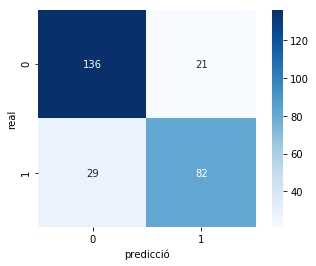

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import confusion_matrix

matrix = confusion_matrix(y_test, predicted)
sns.heatmap(matrix, annot=True, fmt="d", cmap='Blues', square=True)
plt.xlabel("predicció")
plt.ylabel("real")
plt

Nuestro model ha acertado 136 + 82 pasajeros y ha clasificado mal 21 + 29.

### Exactitud o _accuracy_

La exactitud o _accuracy_ es la proporción de ejemplos que se han clasificado correctamente, o lo que es lo mismo, en que la categoría que ha predecido nuestro modelo coincide con la categoría correcta.

La ventaja de esta medida es que es muy sencilla de entender, però tiene muchas limitacions, ya que da una visión demasiado simple de lo que realmente está haciendo el modelo. A continuación veremos otras métricas más complejas y qué motivación tenemos para usarlas para mejorar nuestra visión de lo que está haciendo el model en un conjunto de datos determinado.

![](images/accuracy-v-precision.jpg)

In [13]:
from sklearn.metrics import accuracy_score

accuracy_score(y_test, predicted)

0.8134328358208955

Este resultado nos dice que el 81% de las predicciones que hemos hecho han sido correctas.

### Precisión, exhaustividad, valor-F i soporte

La librería `Scikit-learn` nos ofrece un informe rápido sobre las predicciones que ha hecho nuestro modelo de clasificación. En concreto, nos muestra la precisión y la exhaustividad del modelo (_precision_ and _recall_), el F1-_score_ y el soporte.

In [15]:
from sklearn.metrics import classification_report

report = classification_report(y_test, predicted)
print(report)

             precision    recall  f1-score   support

          0       0.82      0.87      0.84       157
          1       0.80      0.74      0.77       111

avg / total       0.81      0.81      0.81       268



### Área debajo de la curva ROC

El área debajo de la curva es una métrica de rendimiento de un modelo binario de clasifiacación. Representa la habilidad del modelo para discriminar entre las clases negativas y las positivas. Un área de 1 representa un modelo que ha hecho todas las predicciones perfectas, mientras que un área de 0.5 representa el rendimiento de un modelo aleatorio.

La curva ROC muestra la relación entre la especificidad y la sensitividad, dos de las métricas más importantes que marcan la relación entre los falsos positivos y los falsos negativos. Como hemos visto en el apartado de la matriz de confusión, los problemas de clasifiacción suelen ser un equilibrio entre estas dos medidas.

In [16]:
from sklearn.metrics import roc_curve, auc

fpr, tpr, thresholds = roc_curve(y_test, predicted)
roc_auc = auc(fpr, tpr)

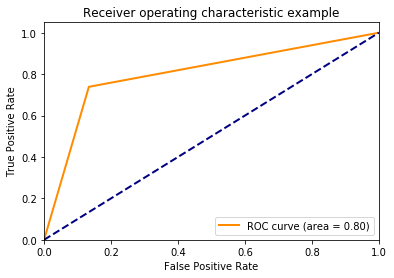

In [17]:
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange', lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

## Conclusión

En esta actividad hemos visto algunas de las métricas más usadas en los problemas de clasificación. Utilizar una o otra dependerá en buena medida de entender cuál es el objetivo del problema.

<!--Footer-->
 <div style="background: #333333;padding: 35px 0px;margin-top: 25px;">
    <div class="row">
     <div class="col-sm-12">
        <img src="http://materials.cv.uoc.edu/cdocent/common/img/logo-uoc-bottom.png" alt="Logo UOC" class="img-responsive" style="margin: 0 auto; display: block;">
    </div>
</div>
</div>
<!--/Footer-->